# Capstone Project - Relocation To Another City

## Table of contents
* [Introduction: Relocation Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Relocation Problem <a name='introduction'></a>

In this project we will try to solve how to find the best place to move from your hometown. Particularly, this work will be targeted to people willing to move from Toronto (Canada) to New York (the USA).

There are many reasons why people decide to relocate, e.g. job offers, weather conditions, relationships and etc. Moving to another city, people still want to feel at home. That is why it is important to find the same conditions for living and choose a house with similar places next to it that people used to visit before they moved. So, the main beneficiaries of this problem solution are considered to be people who are willing to relocate for some reasons and to find comparable urban environment at the same time.

We will use several data science approaches and tools to find out the best places for relocation to New York for people from Toronto. To reduce the amount of computation power used we will explore one borough in each city. As our example task we can consider the following situation: there is a very successful trader who lives in Downtown of Toronto and who got a job offer from one of the best firms of Wall Street, and now he has to decide which Manhattan neighborhood to choose to move to.   

## Data <a name='data'></a>

To implement the following analysis we need information about both of the cities (New York and Toronto) representing as tables with the data about boroughs and neighborhoods of the cities and their geographical coordinates. Specifically, we are going to focus on one borough in each city (Manhattan and Downtown Toronto) Also, the venues that are located next to every neighborhood in selected boroughs should be included in the tables. 

To create these tables we will use some information sources.

* The dataset about New York City is extracted from the spatial data repository of New York University (https://geo.nyu.edu/catalog/nyu_2451_34572) and saved in the **newyork_data.json** file. This dataset contains all the necessary information (boroughs, neighborhoods, geographical coordinates of neighborhoods).

* The data about boroughs and neighborhoods of Toronto with the corresponding postal codes is scraped from the Wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and saved in the **postalcodes.csv** file.  

* The **Geospatial_Coordinates.csv** file contains all the postal codes of Toronto with the corresponding geographical coordinates.

* Centers of each city will be obtained using **Nominatim**, open-source geocoding tool.

* all venues for chosen neighborhoods in each city will be retrieved using **Foursquare API**.

### Data cleaning and preprocessing 

#### First, let's import all the libraries that we will use at this stage

In [88]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import csv
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans # clustering algorithm
from yellowbrick.cluster import KElbowVisualizer # visualizer for k-means elbow method
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


#### Second, let's create the tables for both cities that contain their boroughs, neighborhoods and corresponding geographical coordinates (latitudes and longitudes) using the files mentioned above.

1) New York data do not need to be cleaned, it is just about extracting necessary fields.

In [75]:
# New York data
with open('newyork_data.json') as json_data: # read the data to newyork_data variable
    newyork_data = json.load(json_data)
neighborhoods_newyork_data = newyork_data['features'] # extract only 'features' field
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] # define the dataframe columns
neighborhoods_newyork = pd.DataFrame(columns=column_names) # create the dataframe using pandas
for data in neighborhoods_newyork_data: # populate the dataframe with the data
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    neighborhoods_newyork = neighborhoods_newyork.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
# focus on Manhattan
neighborhoods_manhattan = neighborhoods_newyork[neighborhoods_newyork['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_manhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


2) The data about Toronto after scraping should be cleaned. Also, we have to join information from different files in one table. So, some preprocessing procedures will be needed.

In [3]:
# Toronto data
neighborhoods_toronto = pd.read_csv('postalcodes.csv') # read the data from the csv file to a dataframe

# data cleaning
neighborhoods_toronto = neighborhoods_toronto.drop(np.where(neighborhoods_toronto['Borough'] == 'Not assigned')[0]) # we don't need the rows with the 'Not assigned' boroughs
for i in range(neighborhoods_toronto.shape[0]): # replace '/' with ',' in the Neighborhood column
    neighborhoods_toronto.iloc[i,2] = neighborhoods_toronto.iloc[i,2].replace(' /', ',')
neighborhoods_toronto.sort_values('Postal code', ascending=True, inplace=True) # sort values
neighborhoods_toronto.reset_index(inplace=True) # reset index
neighborhoods_toronto.drop(['index'], axis=1, inplace=True) # drop the appeared 'index' column

# add geographical coordinates
df_coord = pd.read_csv('Geospatial_Coordinates.csv') # read the data from the csv file to a dataframe
neighborhoods_toronto['Latitude'] = df_coord.iloc[:,1:2] # add the column with latitude coordinates
neighborhoods_toronto['Longitude'] = df_coord.iloc[:,2:3] # add the column with longitude coordinates
neighborhoods_toronto.drop(['Postal code'], axis=1, inplace=True) # drop the 'Postal code' column

# focus on Downtown Toronto
neighborhoods_downtown = neighborhoods_toronto[neighborhoods_toronto['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
neighborhoods_downtown.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Rosedale,43.679563,-79.377529
1,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


Let's have a look how many neighborhoods we have in our considered boroughs.

In [4]:
print('There are {} neighborhoods in Manhattan, New York'.format(neighborhoods_manhattan.shape[0])) 

print('There are {} neighborhoods in Downtown Toronto, Toronto'.format(neighborhoods_downtown.shape[0]))                                                               

There are 40 neighborhoods in Manhattan, New York
There are 19 neighborhoods in Downtown Toronto, Toronto


#### Now then we have information about neighborhoods in New York and Toronto we can find all the venues that are next to each neighborhood in these cities using Foursquare API.

In [5]:
# define Foursquare credentials
# you can use your credentials to check everything works
CLIENT_ID = '///'
CLIENT_SECRET = '///'
VERSION = '///' # Foursquare API version

First, let's create a function **getNearbyVenues** that returns a dataframe with not more than 50 venues for each neighborhood in a city within 500 meters. 

In [6]:
def getNearbyVenues (names, latitudes, longitudes, radius=500, limit=50):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create an API request url
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            radius,
            limit)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # create rows for the neighborhood with information about each venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    # create a dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return(nearby_venues)

Implement our function to New York borough and define not more than 50 venues for all Manhattan neighborhoods within 500 meters.

In [106]:
manhattan_venues = getNearbyVenues(neighborhoods_manhattan['Neighborhood'],
                                 neighborhoods_manhattan['Latitude'],
                                 neighborhoods_manhattan['Longitude'])
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Do the same step for Downtown Toronto borough.

In [107]:
downtown_venues = getNearbyVenues(neighborhoods_downtown['Neighborhood'],
                                 neighborhoods_downtown['Latitude'],
                                 neighborhoods_downtown['Longitude'])
downtown_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town, Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


Now we have enough infomation about Manhattan and Downtown Toronto neighborhoods to start looking for the best places to relocate.

## Methodology <a name='methodology'></a>

In this relocation project, we are directing our efforts on finding the Manhattan neighborhoods that are comparable to the Downtown Toronto ones as much as possible to offer these options to people interested in relocation.

First, we have collected all the required data: name, location and category of every venue within 500 meters from centers of all considered neighborhoods using Foursquare API requests.

As we are going to compare neighborhoods of two different cities, these neighborhoods should be compatible to each other. Since our analysis is based on the infrastructure similarities it is important to consider only those venue categories that are  represented in each boroughs (Manhattan and Downtown Toronto) So, in second step, we have to analyze which categories we can leave and which ones we have to drop from our initial datasets.  

Then, we are going to describe each neighborhood in terms of top 10 venues characterized them. One hot encoding technique will be used to identify the weights of each type of venues in the neighborhoods.

During the last step, we will focus on one of the Downtown Toronto neighborhoods and compare it to all the Manhattan neighborhoods by clustering them using k-means clustering technique. After that, the map with the initial Downtown Toronto neighborhood and the Manhattan neighborhoods that are suited for relocation will be presented by means of Folium, map rendering library.

## Analysis <a name='analysis'></a>

### Choose categories that are common for both boroughs

First, let us define how many venues categories are in both boroughs according to Foursqure search engine.

In [9]:
print('There are {} unique venue categories in Manhattan.'.format(len(manhattan_venues['Venue Category'].unique())))
print('There are {} unique venue categories in Downtown Toronto.'.format(len(downtown_venues['Venue Category'].unique())))

There are 279 unique venue categories in Manhattan.
There are 181 unique venue categories in Downtown Toronto.


As we see, Manhattan is pretty much more interesting and deverse. But now let us check how many venue categories Manhattan and Downtown Toronto have in common. 

In [10]:
manhattan_venues_list = manhattan_venues['Venue Category'].unique() # define a list of unique venue categories in Manhattan
downtown_venues_list = downtown_venues['Venue Category'].unique() # define a list of unique venue categories in Downtown Toronto
common_venues_list = [] # create a blank list for common categories
for i in manhattan_venues_list:
    for j in downtown_venues_list:
        if i == j:
            common_venues_list.append(i)

print('There are {} common venue categories in Manhattan and Downtown Toronto.'.format(len(common_venues_list)))

There are 142 common venue categories in Manhattan and Downtown Toronto.


The following analysis will be based on the assumption that this number of venue categories is enough to choose the best place to relocate as this set contains a lot of essential venue categories such as grocery stores, different kinds of restaurants, financial organizations, sport venues, chemist's, cultural places and etc. 

To move to the next analysis stage, we need to modify both datasets dropping the rows that do not contain venue categories from common_venues_list.

In [11]:
# manhattan_venues modification
manhattan_venues = manhattan_venues.loc[manhattan_venues['Venue Category'].isin(common_venues_list)].reset_index()
manhattan_venues.drop(['index'], axis=1, inplace=True)
print(manhattan_venues.shape)
manhattan_venues.head()

(1526, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [12]:
# downtown_venues modification
downtown_venues = downtown_venues.loc[downtown_venues['Venue Category'].isin(common_venues_list)].reset_index()
downtown_venues.drop(['index'], axis=1, inplace=True)
downtown_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"St. James Town, Cabbagetown",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


The last step in this section is to make sure that we have the same venue categories in both datasets.

In [13]:
if len(manhattan_venues['Venue Category'].unique()) == len(downtown_venues['Venue Category'].unique()):
    print('Manhattan and Downtown Toronto venues datasets have the same set of venue categories')

Manhattan and Downtown Toronto venues datasets have the same set of venue categories


All modifications needed have been done. Now we can move to the part where we will define top 10 venues for each neighborhood.

### Get top 10 venues for each neighborhood

Understanding more popular venues in each neighborhood will be very useful at the final stage of making a decision about which neighborhood to choose to move to because the final range of chosen neighborhoods will much more likely be consisted of more than one option.

As the steps for analyzing Manhattan and Downtown Toronto neighborhoods are pretty the same, Manhattan neighborhood analysis is going to be carried out in details with some explanation notes and analysis for Downtown Toronto neighborhoods will be shown in a short form.

To start choosing the top 10 venues for each neighborhood in Manhattan we need to use one hot encoding technique to get the weights of each venue category in each neighborhood.

In [14]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood']

# move Neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,...,Tailor Shop,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, let's group all the rows in the table by the neighborhoods.

In [15]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,...,Tailor Shop,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Battery Park City,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,Carnegie Hill,0.022222,0.0,0.000000,0.022222,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.022222,0.022222,0.044444
2,Central Harlem,0.055556,0.0,0.027778,0.000000,0.0,0.000000,0.000000,0.027778,0.0,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Chelsea,0.075000,0.0,0.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.00000,0.05,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,Chinatown,0.071429,0.0,0.000000,0.000000,0.0,0.047619,0.000000,0.000000,0.0,...,0.0,0.02381,0.02381,0.00,0.0,0.0,0.0,0.000000,0.000000,0.023810


To determine top 10 venues for each Manhattan neighborhood, we need to define a function that is to take all the categories' weigths in each neighborhood, put them in a descending order and display the assigned amount of these categories (in our case, 10 categories).

In [16]:
def return_most_common_venues(rows, num_top_venues):
    row_categories = rows.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, let us implement this function to manhattan_grouped dataset. First, set the number of top venues. Next, create the head of the table. Then, populate the table using the written function.

In [17]:
num_top_venues = 10

# create columns according to the number of the top venues (not more than 20)
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for i in range(num_top_venues):
    try:
        columns.append('{}{} common venue'.format(i+1,indicators[i]))
    except:
        columns.append('{}th common venue'.format(i+1))

# create a new dataframe        
manhattan_venues_sorted = pd.DataFrame(columns=columns)
manhattan_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood'] # copy the names of Manhattan neighborhoods
for i in range(manhattan_grouped.shape[0]): # populate each row of the new table
    manhattan_venues_sorted.iloc[i, 1:] = return_most_common_venues(manhattan_grouped.iloc[i, :], num_top_venues)

manhattan_venues_sorted.head()

,Neighborhood,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
0,Battery Park City,Park,Hotel,Gym,Plaza,Shopping Mall,Food Court,Gourmet Shop,Performing Arts Venue,Bistro,Pub
1,Carnegie Hill,Bookstore,Italian Restaurant,Café,Coffee Shop,Gym / Fitness Center,Yoga Studio,Pizza Place,Gym,French Restaurant,Grocery Store
2,Central Harlem,American Restaurant,Chinese Restaurant,French Restaurant,Fried Chicken Joint,Bar,Seafood Restaurant,Gym / Fitness Center,Park,Ethiopian Restaurant,Event Space
3,Chelsea,Coffee Shop,American Restaurant,Seafood Restaurant,Art Gallery,Theater,Italian Restaurant,Market,Bakery,Hotel,Ice Cream Shop
4,Chinatown,American Restaurant,Chinese Restaurant,Spa,Ice Cream Shop,Salon / Barbershop,Greek Restaurant,Sandwich Place,Asian Restaurant,Boutique,Roof Deck


We do the same steps for Downtown Toronto neighborhoods (dowtown_venues dataset). 

In [54]:
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix='', prefix_sep='')
downtown_onehot['Neighborhood'] = downtown_venues['Neighborhood']
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()

downtown_venues_sorted = pd.DataFrame(columns=columns)
downtown_venues_sorted['Neighborhood'] = downtown_grouped['Neighborhood']
for i in range(downtown_grouped.shape[0]):
    downtown_venues_sorted.iloc[i, 1:] = return_most_common_venues(downtown_grouped.iloc[i, :], num_top_venues)

downtown_venues_sorted

,Neighborhood,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Bakery,Restaurant,Café,Seafood Restaurant,Clothing Store,Farmers Market
1,"CN Tower, King and Spadina, Railway Lands, Har...",Boutique,Sculpture Garden,Harbor / Marina,Boat or Ferry,Bar,Event Space,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant
2,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Bubble Tea Shop,Ice Cream Shop,Bar,Ramen Restaurant,Falafel Restaurant
3,Christie,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Diner,Coffee Shop,Athletics & Sports,Baby Store,Nightclub
4,Church and Wellesley,Coffee Shop,Restaurant,Yoga Studio,Sushi Restaurant,Japanese Restaurant,Men's Store,Gastropub,Thai Restaurant,Caribbean Restaurant,Arts & Crafts Store
5,"Commerce Court, Victoria Hotel",Hotel,Café,Coffee Shop,Gym,American Restaurant,Beer Bar,Japanese Restaurant,Deli / Bodega,Restaurant,Seafood Restaurant
6,"First Canadian Place, Underground city",Café,Coffee Shop,Restaurant,Japanese Restaurant,Gym,Hotel,Tea Room,Seafood Restaurant,Deli / Bodega,Concert Hall
7,"Garden District, Ryerson",Café,Middle Eastern Restaurant,Tea Room,Ramen Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Bookstore,Restaurant,Theater
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Park,Plaza,Hotel,Café,Japanese Restaurant,Scenic Lookout,Dance Studio,Italian Restaurant,Salad Place
9,"Kensington Market, Chinatown, Grange Park",Café,Coffee Shop,Mexican Restaurant,Bakery,Dessert Shop,Gaming Cafe,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Park,Cocktail Bar


We have got now top 10 venues for all neighborhoods in Manhattan and Downtown Toronto we have. At this stage it is possible to carry out qualitative analysis and compare neighborhoods to each other according to the top venues. But it is also a good idea to implement a quantitative analysis using on of the machine learning techniques.

### Cluster concatenated neighborhoods

As our data is unlabeled it is justified to use clustering tools. I chose for this purpose the one that is called **k-means clustering**.

To start clustering it is necessary to preprocess some data and create a new concatenated dataset that includes all the data about Manhattan neighborhoods and one of the Downtown Toronto neighborhoods that we move from. That is one of the main reasons why having equal venue categories in each neighborhood is crucial.

Let us assume that our person living in Downtown Toronto is the resident of the **'Regent Park, Harbourfront'** neighborhood. First, let us extract this row from the toronto_grouped dataset and store it as a new dataframe.

In [51]:
chosen_row = downtown_grouped.loc[downtown_grouped['Neighborhood'] =='Regent Park, Harbourfront']
chosen_row

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,...,Tailor Shop,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
11,"Regent Park, Harbourfront",0.0,0.021277,0.021277,0.0,0.0,0.021277,0.0,0.0,0.0,...,0.0,0.0,0.0,0.042553,0.0,0.0,0.0,0.0,0.0,0.021277


Next, concatenate Manhattan neighborhoods with our chosen one. 

In [53]:
concat_grouped = pd.concat([manhattan_grouped, chosen_row])
concat_grouped.reset_index(drop=True, inplace=True)
concat_grouped.tail()

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,...,Tailor Shop,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
36,Upper West Side,0.051282,0.000000,0.000000,0.0,0.025641,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.051282,0.000000,0.0,0.025641,0.0,0.000000,0.051282,0.000000
37,Washington Heights,0.027027,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
38,West Village,0.023810,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.02381,0.000000,0.023810,0.0,0.000000,0.0,0.000000,0.071429,0.000000
39,Yorkville,0.000000,0.000000,0.000000,0.0,0.000000,0.023256,0.0,0.0,0.0,...,0.0,0.00000,0.023256,0.000000,0.0,0.000000,0.0,0.023256,0.023256,0.000000
40,"Regent Park, Harbourfront",0.000000,0.021277,0.021277,0.0,0.000000,0.021277,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.042553,0.0,0.000000,0.0,0.000000,0.000000,0.021277


We see that information about the chosen Downtown Toronto neighborhood and Manhattan neighborhoods have been successfully concatenated. Now we can move to the clustering stage itself.

First, we will drop the 'Neighborhood' column because k-means algorythm deals with digitals only. Next, we will choose the best k number to cluster our neighborhoods using 'elbow method'. Then, we will define k number, cluster the neiborhoods and get the labels for all of them.

In [55]:
# drop the neighborhood column
concat_grouped_clustering = concat_grouped.drop('Neighborhood', 1)
concat_grouped_clustering.head()

,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,...,Tailor Shop,Tea Room,Thai Restaurant,Theater,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,0.000000,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.022222,0.0,0.000000,0.022222,0.0,0.000000,0.000000,0.000000,0.0,0.022222,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.022222,0.022222,0.044444
2,0.055556,0.0,0.027778,0.000000,0.0,0.000000,0.000000,0.027778,0.0,0.027778,...,0.0,0.00000,0.00000,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.075000,0.0,0.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.025000,...,0.0,0.00000,0.00000,0.05,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.071429,0.0,0.000000,0.000000,0.0,0.047619,0.000000,0.000000,0.0,0.000000,...,0.0,0.02381,0.02381,0.00,0.0,0.0,0.0,0.000000,0.000000,0.023810


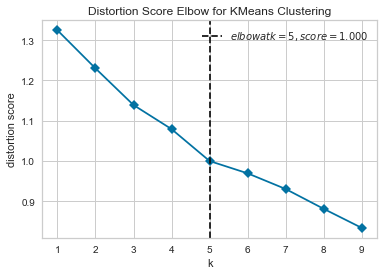

In [64]:
# run k-means clustering with different ks
# Instantiate the clustering model and visualizer
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(1,10), timings=False)

visualizer.fit(concat_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The graph above shows almost linear relathionship between the k number and the distortion parameter. Since there is no precise elbow on the graph it is suggested that we take an option with k=5 to cluster the neighborhoods.

In [67]:
# set number of clusters
num_clusters = 5
kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(concat_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 4, 4, 2, 1, 2, 1, 1, 2, 2, 2, 3,
       3, 1, 1, 3, 1, 4, 3, 4, 3, 1, 0, 2, 0, 1, 4, 2, 4, 4, 2])

This concludes the clustering stage where all analyzed neighborhoods have been divided into 5 clusters.

### Aggregate and map the findings

Before mapping the results, it is important to upgrade some of the tables. We need to modify *neighborhoods_manhattan*  and *manhattan_venues_sorted* datasets by adding a row with **'Regent Park, Harbourfront'** neighborhood.

In [70]:
# extract a row
chosen_row1 = neighborhoods_downtown.loc[neighborhoods_downtown['Neighborhood'] =='Regent Park, Harbourfront']
# concatenate it
concat_neighborhoods_manhattan = pd.concat([neighborhoods_manhattan, chosen_row1])
concat_neighborhoods_manhattan.reset_index(drop=True, inplace=True)
concat_neighborhoods_manhattan.tail()

,Borough,Neighborhood,Latitude,Longitude
36,Manhattan,Tudor City,40.746917,-73.971219
37,Manhattan,Stuyvesant Town,40.731000,-73.974052
38,Manhattan,Flatiron,40.739673,-73.990947
39,Manhattan,Hudson Yards,40.756658,-74.000111
40,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636


In [71]:
# extract a row
chosen_row2 = downtown_venues_sorted.loc[downtown_venues_sorted['Neighborhood'] =='Regent Park, Harbourfront']
# concatenate it
concat_manhattan_venues_sorted = pd.concat([manhattan_venues_sorted, chosen_row2])
concat_manhattan_venues_sorted.reset_index(drop=True, inplace=True)
concat_manhattan_venues_sorted.tail()

,Neighborhood,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
36,Upper West Side,Italian Restaurant,Bakery,American Restaurant,Thai Restaurant,Seafood Restaurant,Bookstore,Wine Bar,Ice Cream Shop,Coffee Shop,Middle Eastern Restaurant
37,Washington Heights,Café,New American Restaurant,Chinese Restaurant,Pizza Place,Park,Deli / Bodega,Coffee Shop,Bakery,Liquor Store,Lounge
38,West Village,Italian Restaurant,Park,Wine Bar,Cocktail Bar,Boutique,French Restaurant,Jazz Club,Bakery,New American Restaurant,Coffee Shop
39,Yorkville,Italian Restaurant,Coffee Shop,Deli / Bodega,Park,Gym,Sandwich Place,Monument / Landmark,Burger Joint,Indian Restaurant,Butcher
40,"Regent Park, Harbourfront",Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Playground,Performing Arts Venue


Everything looks as it is prepared for the following analysis. Now let us add claster labels to *concat_manhattan_venues_sorted* dataset.


In [72]:
concat_manhattan_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
concat_manhattan_venues_sorted.tail()

,Neighborhood,Cluster Labels,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
36,Upper West Side,4,Italian Restaurant,Bakery,American Restaurant,Thai Restaurant,Seafood Restaurant,Bookstore,Wine Bar,Ice Cream Shop,Coffee Shop,Middle Eastern Restaurant
37,Washington Heights,2,Café,New American Restaurant,Chinese Restaurant,Pizza Place,Park,Deli / Bodega,Coffee Shop,Bakery,Liquor Store,Lounge
38,West Village,4,Italian Restaurant,Park,Wine Bar,Cocktail Bar,Boutique,French Restaurant,Jazz Club,Bakery,New American Restaurant,Coffee Shop
39,Yorkville,4,Italian Restaurant,Coffee Shop,Deli / Bodega,Park,Gym,Sandwich Place,Monument / Landmark,Burger Joint,Indian Restaurant,Butcher
40,"Regent Park, Harbourfront",2,Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Playground,Performing Arts Venue


To display all the clustered neighborhoods on the map, we need to have geographical coordinated for each neighborhood. Since we have already extracted them previously, let us merge *concat_manhattan_venues_sorted* and *concat_neighborhoods_manhattan* datasets.

In [73]:
merged_dataset = concat_neighborhoods_manhattan.join(concat_manhattan_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
merged_dataset.tail()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
36,Manhattan,Tudor City,40.746917,-73.971219,2,Park,Café,Vietnamese Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Yoga Studio,Italian Restaurant,Plaza
37,Manhattan,Stuyvesant Town,40.731000,-73.974052,3,Park,Boat or Ferry,Bar,Harbor / Marina,Playground,Coffee Shop,Cocktail Bar,Farmers Market,Fountain,Gym / Fitness Center
38,Manhattan,Flatiron,40.739673,-73.990947,1,Cosmetics Shop,Yoga Studio,Sporting Goods Shop,Bakery,Gym,Italian Restaurant,Japanese Restaurant,American Restaurant,Grocery Store,Bookstore
39,Manhattan,Hudson Yards,40.756658,-74.000111,1,American Restaurant,Italian Restaurant,Hotel,Gym / Fitness Center,Park,Café,Coffee Shop,Gym,Furniture / Home Store,Performing Arts Venue
40,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Playground,Performing Arts Venue


To set the initial view of two cities together to the map we need to calculate the geographical coordinates of the point between these cities. We are going to retrieve the coordinates of two cities using Nominatim tool and then get the average values.

In [87]:
addresses = ['Toronto, Canada', 'New York, USA']
lats, lngs = [], []
for i in addresses:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude
    lats.append(latitude)
    lngs.append(longitude)
    print('The geographical coordinates of {} are {}, {}.'.format(i,latitude, longitude))

latitude = (lats[0]+lats[1])/2
longitude = (lngs[0]+lngs[1])/2
print('The coordinates of the point between two cities are ({}, {}).'.format(latitude, longitude))

The geographical coordinates of Toronto, Canada are 43.6534817, -79.3839347.
The geographical coordinates of New York, USA are 40.7127281, -74.0060152.
The coordinates of the point between two cities are (42.183104900000004, -76.69497494999999).


Now then there is all necessary infomation, we can create a map and display all Manhattan neighborhoods and the one from Downtown Toronto.

In [102]:
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lng, neigh, cluster in zip(merged_dataset['Latitude'], merged_dataset['Longitude'], merged_dataset['Neighborhood'], merged_dataset['Cluster Labels']):
    label = folium.Popup(str(neigh) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

The map that we got shows us two cities in one picture. But to look closely at Manhattan neighborhoods we need to zoom in there a couple of times. Since we aim to the neighborhoods that are in the same cluster as **'Regent Park, Harbourfront'** neighborhood, let us filter *merged_dataset* and extract only those rows that contain cluster labels we need. In our case, this is a cluster 2.

In [108]:
filtered_merged_dataset = merged_dataset[merged_dataset['Cluster Labels'] == 2].reset_index(drop=True)
filtered_merged_dataset.tail()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st common venue,2nd common venue,3rd common venue,4th common venue,5th common venue,6th common venue,7th common venue,8th common venue,9th common venue,10th common venue
6,Manhattan,Lower East Side,40.717807,-73.980890,2,Chinese Restaurant,Cocktail Bar,Coffee Shop,Park,Café,Art Gallery,Ice Cream Shop,Ramen Restaurant,French Restaurant,Playground
7,Manhattan,Little Italy,40.719324,-73.997305,2,Mediterranean Restaurant,Pizza Place,Thai Restaurant,Bakery,Café,Seafood Restaurant,Clothing Store,Coffee Shop,Noodle House,Chinese Restaurant
8,Manhattan,Manhattan Valley,40.797307,-73.964286,2,Yoga Studio,Thai Restaurant,Chinese Restaurant,Coffee Shop,Bar,Pizza Place,Bubble Tea Shop,Café,Caribbean Restaurant,Bakery
9,Manhattan,Tudor City,40.746917,-73.971219,2,Park,Café,Vietnamese Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Deli / Bodega,Yoga Studio,Italian Restaurant,Plaza
10,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Pub,Park,Bakery,Theater,Breakfast Spot,Café,Farmers Market,Playground,Performing Arts Venue


Let us map only these neighborhoods and focus the view on Manhattan island.

In [109]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Manhattan, New York, USA')
lat_ny = location.latitude
lng_ny = location.longitude

map_clusters_2 = folium.Map(location=[lat_ny,lng_ny], zoom_start=11)

# add markers to the map
for lat, lng, neigh, cluster in zip(filtered_merged_dataset['Latitude'], filtered_merged_dataset['Longitude'], filtered_merged_dataset['Neighborhood'], filtered_merged_dataset['Cluster Labels']):
    label = folium.Popup(str(neigh) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#9933ff',
        fill_opacity=0.7).add_to(map_clusters_2)
    
map_clusters_2

On the map presented above, we can find 10 Manhattan neighborhoods that are recommended as similar ones to **'Regent Park, Harbourfront'** neighborhood from the perspectives of venues located next to and within these neighborhoods.

## Results <a name='results'></a>

The main result of this work is the final set of 10 Manhattan neighborhoods that can be recommended as potential places for relocation to Manhattan from **'Regent Park, Harbourfront'** Toronto neighborhood. These recommendations are based on the idea of similarity of venues that are typical for these neighborhoods. Initially, there were 40 Manhattan neighborhoods that we started analysis with.

Any of the Downtown Toronto neighborhoods can be chosen as the initial one. According to the initial neighborhood, a unique set of similar Manhattan neighborhoods can be received. Neighborhoods from the generated set are presented on the map and labeled with their names.

## Discussion <a name='discussion'></a>

This project can be considered as the first step for making a recommendation system for people willing to relocate to another city and finding a place that is similar to their previous residence.
Of course, there are plenty of things that can be done to make this system stronger. Here are some of them:
1. This system shouldn't be restricted by two possible cities. It could be a good idea to start with one of the region and then to expand it to a country level or higher.
2. While making a decision about a place to relocate to, the system should take into account not only the information about the venues of the neighborhoods but also the data about real estate prices, crime rate, level of noise and etc.
3. For this project, it is also a good idea to standardized venue categories and use their variety to make the results more accurate, because in our analysis we had to drop some venue categories reduced their number to 143 although there were initially 279 and 181 different venue categories in Manhattan and Downtown Toronto, correspondingly.

## Conclusion <a name='conclusion'></a>

Purpose of this project was to identify the range of best places to relocate to Manhattan for a trader from Downtown Toronto who's recently got the job on Wall Street.
To describe each neighborhood in these boroughs, the data about venues next to and within these neighborhoods was extracted from Foursquare database. One of the Downtown Toronto neighborhoods then was chosen as the initial one where we suppose our trader lives. To match Manhattan and Downtown Toronto neighborhoods it was necessary to standardize their descriptions. After standardizing descriptions of neighborhoods by dropping unequal venue categories, there was a clustering stage which helped to divide all the neighborhoods including the initial one into five clusters. The cluster containing the initial neighborhood became a target one.

This target cluster provides the trader from the example task with the information that can help him to make a better final decision on choosing the place to relocate faster.